# Recurrent GAN for Time Series Generation
On this notebook, we’ll get hands-on with using **Recurrent GAN** model to tackle a generation task. Along the way, you’ll see how the model is built and trained on a specific dataset, and pick up the key ideas so that you can apply them to your own projects with your own data

## Import Libraries

This notebook relies on a set of libraries for time series forecasting and analysis. These include:

- **Pandas / NumPy** for tabular and numerical operations  
- **Hugging Face Datasets** for loading benchmark datasets  
- **Custom `genai4t` utilities** developed for this book to streamline preprocessing, training, and evaluation  
- **Matplotlib** for visualization  

We organize the imports below for clarity.

In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
import random
import pandas as pd
from lightning import seed_everything
import torch
from datasets import load_dataset
from genai4t.utils import set_random_state, get_torch_device
from genai4t.data.processing import (
    split_timeseries_with_length,
    dataset_to_pandas
)
from sklearn.model_selection import train_test_split
from genai4t.plot_style import plot_style

## Experiment Configuration

To keep our experiments organized, we define all key parameters (e.g., model hyperparameters, dataset settings, training options) as configuration dictionaries

This allows us to:
- Easily adjust settings in one place
- Avoid hardcoding values throughout the notebook

In [2]:
ENV_CONFIG = {
        'random_state': 2024,
        'use_cuda': True
    }

DATA_CONFIG = {
        'name':  "gatam4t/genai4t_spx_generation",
        'batch_size': 16,
        'sequence_len': 20,
        "num_eval_iterations": 50,
    }

In [3]:
set_random_state(ENV_CONFIG["random_state"])
device = get_torch_device()

Seed set to 2024


## Load Data

In this experiment, we use time series data derived from the **S&P 500 Index (SPX)**, a benchmark index that tracks the performance of 500 of the largest publicly traded companies in the United States. Specifically, the dataset contains two time series:

•⁠  ⁠The log return of the closing price
•⁠  ⁠The log of the Median Realized Volatility

These values span the period from 2005-01-01 to 2020-06-01, and have been standardized to have a mean of 0 and a standard deviation of 1.

The data originates from the [Oxford-Man Realized Volatility Indices dataset](https://github.com/onnokleen/mfGARCH/raw/v0.1.9/data-raw/OxfordManRealizedVolatilityIndices.zip), published by the Oxford-Man Institute of Quantitative Finance (University of Oxford) in collaboration with Man Group, a global active investment management firm. This dataset is widely used in academic research and provides daily realized volatility measures computed from high-frequency intraday financial data.

To make access easier and ensure long-term reproducibility, a copy of the dataset processed has been published in the Hugging Face repo associated with this book. We'll load it directly from there.

While we use this dataset for generation notebooks, the methods in this notebook work with any dataset in wide time series format (i.e., one time series per column) with minimal adjustments.

In [4]:
dataset = load_dataset(DATA_CONFIG["name"], split='train')

# Convert to pandas DataFrame and enforce consistent time frequency
data = dataset_to_pandas(dataset)

# Display the first few rows of the DataFrame
data.head()

,logreturn,logvol
0,-0.979992,0.212416
1,-0.335923,0.438473
2,0.244094,-0.069770
3,-0.132698,0.087008
4,0.257988,-0.278999


In [5]:
# the data have been standardized
data.describe().T

,count,mean,std,min,25%,50%,75%,max
logreturn,3394.0,-3.371860e-09,1.0,-8.298640,-0.356489,0.033435,0.429621,9.072744
logvol,3394.0,-5.934473e-07,1.0,-2.290916,-0.676626,-0.136567,0.602935,4.178672


In [6]:
# transform dataframe into a numpy array
data_as_array = data.to_numpy().astype(np.float32)

In [7]:
data_as_array

array([[-0.979992  ,  0.21241626],
       [-0.33592334,  0.43847257],
       [ 0.24409448, -0.06976987],
       ...,
       [-1.195638  ,  1.0179971 ],
       [ 0.1652753 ,  0.08472553],
       [-0.74991983,  0.80158144]], dtype=float32)

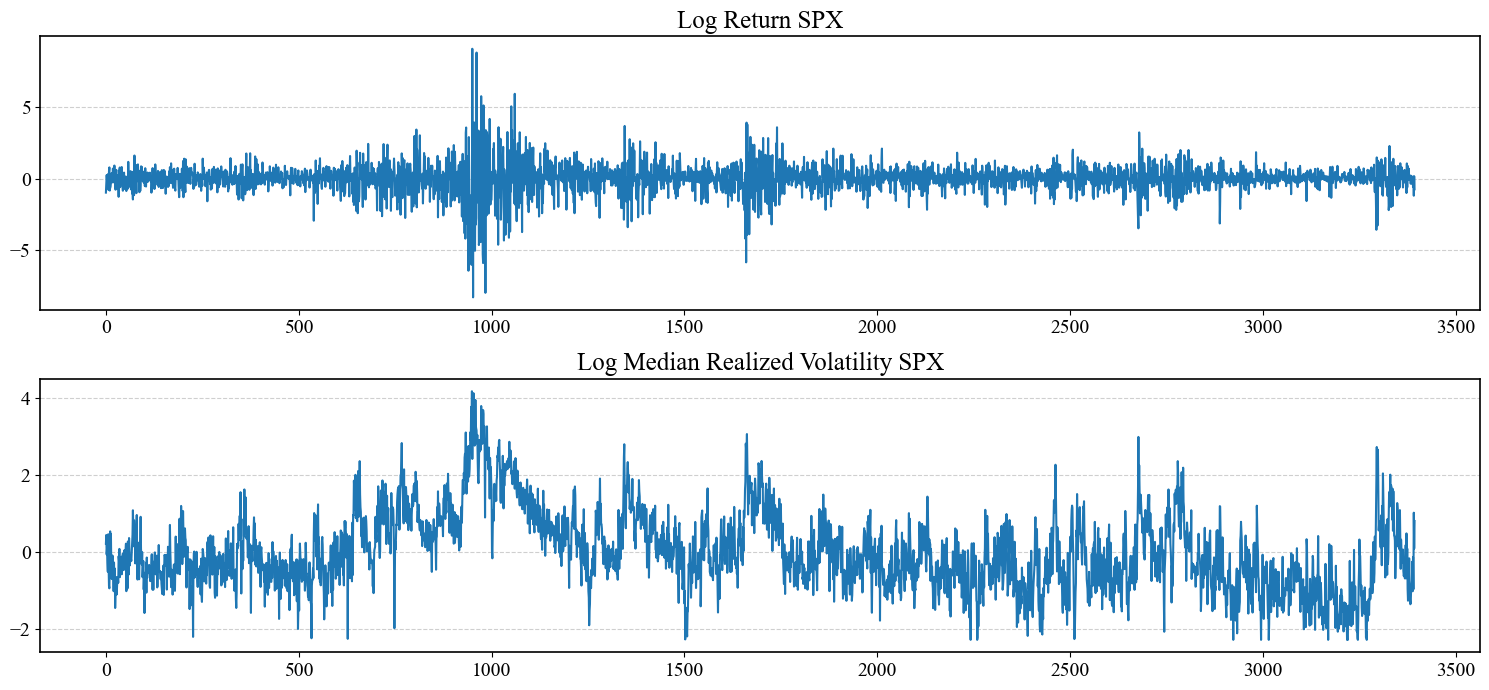

In [8]:
f, axs = plt.subplots(2, 1, figsize=(15, 7))
axs[0].plot(data_as_array[:, 0])
axs[0].set_title("Log Return SPX")
plot_style.apply_plot_style(axs[0])
plot_style.apply_grid(axs[0])
axs[1].plot(data_as_array[:, 1])
axs[1].set_title("Log Median Realized Volatility SPX")
plot_style.apply_plot_style(axs[1])
plot_style.apply_grid(axs[1])

## Sequence Generation

Our models will generate new time series of fixed length `sequence_len`, so we need to transform our historical data into this format. We accomplish this by using the `split_timeseries_with_length` function.

In [9]:
# creates sequence
sequences = split_timeseries_with_length(data_as_array, DATA_CONFIG["sequence_len"])

In [10]:
sequences.shape

(3375, 20, 2)

In [11]:
_, seq_len, feat_dim = sequences.shape 

In [12]:
seq_len

20

In [13]:
feat_dim

2

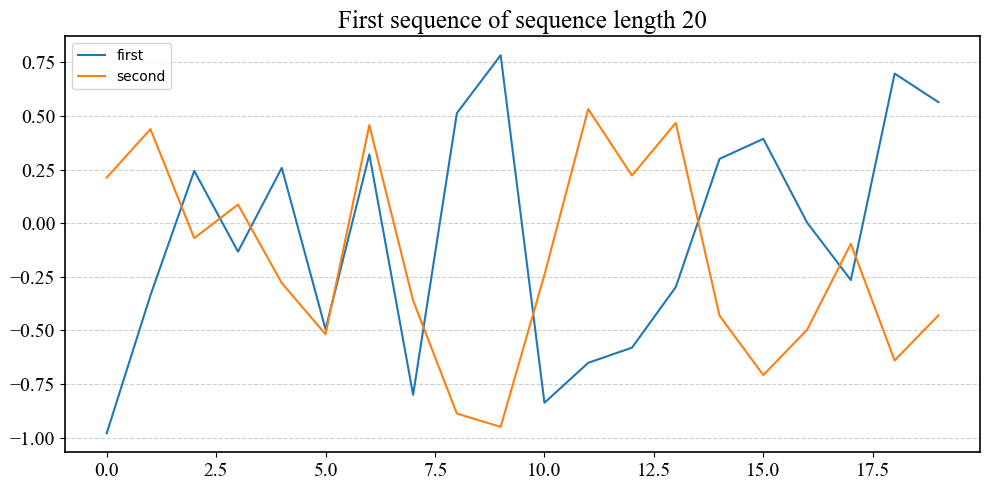

In [14]:
f, ax = plt.subplots(figsize=(10, 5))
ax.plot(sequences[0, :, 0], label='first')
ax.plot(sequences[0, :, 1], label='second')
plot_style.apply_grid(ax)
ax.set_title(f"First sequence of sequence length {seq_len}")
plot_style.apply_plot_style(ax)
ax.legend()
plt.show()

## Split the Dataset into Train/Test
We split the sequences into training and testing sets, with 20% of the data reserved for testing. To ensure reproducibility, we use the `random_state=ENV_CONFIG["random_state"]` parameter.

In [15]:
train_data, test_data = train_test_split(
    sequences,
    test_size=0.2,
    random_state=ENV_CONFIG["random_state"])

In [16]:
train_data.shape

(2700, 20, 2)

In [17]:
test_data.shape

(675, 20, 2)

## Setting Up the Training Dataloader

We will create a DataLoader using PyTorch's built-in implementation to handle batching.

In [18]:
from torch.utils.data import DataLoader

In [19]:
train_dl = DataLoader(train_data, batch_size=DATA_CONFIG["batch_size"], shuffle=True)

In [20]:
# Number of batches
len(train_dl)

169

In [21]:
# Fetch a single batch from the DataLoader
batch = next(iter(train_dl))
# batch size time series of length sequence_len!
batch.shape

torch.Size([16, 20, 2])

## Recurrent GAN (RGAN)

[RGAN](https://arxiv.org/abs/1706.02633) by Esteban et al. (2017) is a model proposed to extend the GAN framework for generating more realistic time series data.

It uses RNNs for both the generator and discriminator, which means that the data are generated sequentially. The objective of using RNNs is to allow the model to capture the serial correlations or temporal dynamics present in time series data, adapting the standard GANs to better model time series dynamics. 


The authors of RGAN originally applied the model to medical time series, and now this model is commonly used as a common benchmark for evaluating generative models on time series data. If you want to learn more about their original results on medical data, we invite you to check out their paper [Real-valued (Medical) Time Series Generation with Recurrent Conditional GANs](https://arxiv.org/abs/1706.02633). In this notebook, we will explore how RGAN performs on financial time series instead.



Because RGAN builds on concepts from both GANs and RNNs, we recommend reviewing Chapters 3, 5, and 8 of the book, along with the GANs tutorial notebook in Chapter 08 of this repository for implementation details on the `GanModule`.




### Generator and Discriminator Networks


As in standard GANs, training involves learning two models:

- The **Generator** $ G $, which takes as input a random vector $ z $ from a latent space (typically sampled from a standard normal distribution) and produces synthetic time series data.
- The **Discriminator** $ D $, which receives either real data (from the training set) or synthetic data (from the generator), and learns to classify whether the input is real or fake.

The main difference in RGAN is that both the generator and the discriminator are RNNs.

Specifically:


#### Generator

The generator takes a latent vector $ z \sim \mathcal{N}(0, I) $ of shape `[sequence_len, n_feat]` and passes it through a recurrent neural network (in this implementation, a `GRU` layer) to produce a time series output of the same shape.


#### Discriminator

The discriminator takes a time series of shape `[sequence_len, n_feat]` and applies a recurrent neural network, a `GRU` layer, followed by a classifier head that outputs the probability that the input sequence is real (i.e., coming from the real dataset).




## RGAN Implementation

In [22]:
# Import necessary modules

# - GRULayer: custom GRU Layer
from genai4t.model.layers import GRULayer

# - fit_model: utility to handle model training
# - init_linear_weights: for weight initialization
# - SampleTimeSeries: for sampling latent noise vectors
from genai4t.model.utils import fit_model, init_linear_weights, SampleTimeSeries

# - GanModule: generic GAN training module
from genai4t.chapters.gans import GanModule

In [23]:
# Define model configuration parameters
MODEL_CONFIG = {
    'lr': 0.0002, # Learning rate for training 
    'latent_dim': 8, # Latent dimension for the noise vector
    'hidden_dim': 24, # Hidden dimension size for GRUs
    'num_layers': 1,  # Number of GRU layers
    'model_dir': './artifacts/rgan', # Directory to store training artifacts
    'steps': 169 * 100,  # Number of training steps
}

In [24]:
# Define the generator network
generator = GRULayer(
    MODEL_CONFIG["latent_dim"], # Input: latent vector
    MODEL_CONFIG["hidden_dim"], # Hidden size for GRUs
    feat_dim,  # Output: feature dimension
    MODEL_CONFIG["num_layers"], # Number of layers
    act_fn=None)

# Define the discriminator network
discriminator = GRULayer(
    feat_dim, # Input: feature dimension
    MODEL_CONFIG["hidden_dim"], # Hidden size for GRUs
    1, # Output
    MODEL_CONFIG["num_layers"], # Number of layers
    act_fn=None)

In [25]:
generator

GRULayer(
  (rnn): GRU(8, 24, batch_first=True)
  (mlp): Linear(in_features=24, out_features=2, bias=True)
)

In [26]:
discriminator

GRULayer(
  (rnn): GRU(2, 24, batch_first=True)
  (mlp): Linear(in_features=24, out_features=1, bias=True)
)

In [27]:
# Create a sampler 
sampler = SampleTimeSeries(seq_len, MODEL_CONFIG["latent_dim"])

In [28]:
# Build the RGAN model using GanModule
# - generator: GRU-based generator
# - discriminator: GRU-based discriminator
# - sampler: latent space sampler
# Apply weight initialization

rgan = GanModule(
    generator,
    discriminator,
    sampler,
    lr=MODEL_CONFIG["lr"],
    clip_gradient_norm=1. # Clip gradients for stability
).apply(init_linear_weights)

In [29]:
rgan

GanModule(
  (generator): GRULayer(
    (rnn): GRU(8, 24, batch_first=True)
    (mlp): Linear(in_features=24, out_features=2, bias=True)
  )
  (discriminator): GRULayer(
    (rnn): GRU(2, 24, batch_first=True)
    (mlp): Linear(in_features=24, out_features=1, bias=True)
  )
  (sampler): SampleTimeSeries()
  (_bce_loss): BCEWithLogitsLoss()
)

In [30]:
# Train the RGAN model
trainer = fit_model(
    logdir=MODEL_CONFIG["model_dir"],
    model=rgan,
    train_dl=train_dl,
    num_steps=MODEL_CONFIG["steps"],
    random_state=ENV_CONFIG["random_state"],
    plot=False)

Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name          | Type              | Params | Mode 
------------------------------------------------------------
0 | generator     | GRULayer          | 2.5 K  | train
1 | discriminator | GRULayer          | 2.0 K  | train
2 | sampler       | SampleTimeSeries  | 0      | train
3 | _bce_loss     | BCEWithLogitsLoss | 0      | train
------------------------------------------------------------
4.5 K     Trainable params
0         Non-trainable params
4.5 K     Total params
0.018     T

total_n_params: 4539


/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |                                                                                                   …

`Trainer.fit` stopped: `max_steps=16900` reached.


## Unconditional Generation

We will sample latent vectors from a standard normal distribution $ z \sim \mathcal{N}(0, I)$ and use the generator network to produce new time series.

In [31]:
# Set the model to evaluation mode and move it to the appropriate device
rgan.eval()
rgan.to(device)

GanModule(
  (generator): GRULayer(
    (rnn): GRU(8, 24, batch_first=True)
    (mlp): Linear(in_features=24, out_features=2, bias=True)
  )
  (discriminator): GRULayer(
    (rnn): GRU(2, 24, batch_first=True)
    (mlp): Linear(in_features=24, out_features=1, bias=True)
  )
  (sampler): SampleTimeSeries()
  (_bce_loss): BCEWithLogitsLoss()
)

In [32]:
# Set random seed for reproducibility
set_random_state(ENV_CONFIG["random_state"])

# Define the number of synthetic samples to generate
num_samples = len(test_data) * DATA_CONFIG['num_eval_iterations']

# Sample noise from the latent space
z = sampler.sample(num_samples).to(device)

# Generate synthetic time series
with torch.no_grad():
    synthetic_data = generator(z)
    synthetic_data_iters = synthetic_data.cpu().numpy()
    synthetic_data_iters = synthetic_data_iters.reshape(-1, *test_data.shape)

Seed set to 2024


## Evaluation

Now that we've generated synthetic data, it's time to evaluate its performance.

We'll use the metrics described in the `EvaluationGenerativeModels.ipynb` notebook, so feel free to check it out if any of the metrics seem unfamiliar.

Note that the `synthetic_data_iters` array has the shape `(num_eval_iterations, test_size, sequence_len, n_feat)`. This is because we calculate the **discriminator scores** and **predictive scores** across `num_eval_iterations`. Since we generate data by sampling from the latent space, each iteration may yield different scores. Running multiple iterations helps ensure more reliable and robust scores.

In [33]:
from genai4t.evaluation.generation.visualize import (
    visualize_2d_pca,
    visualize_2d_tsne,
    visualize_time_series)
from genai4t.evaluation.generation.bp import evaluate

In [34]:
# take the first iteration and use it to compute visual metrics
first_synthetic_data = synthetic_data_iters[0]

### Visualization
Let's visualize real versus synthetic time series

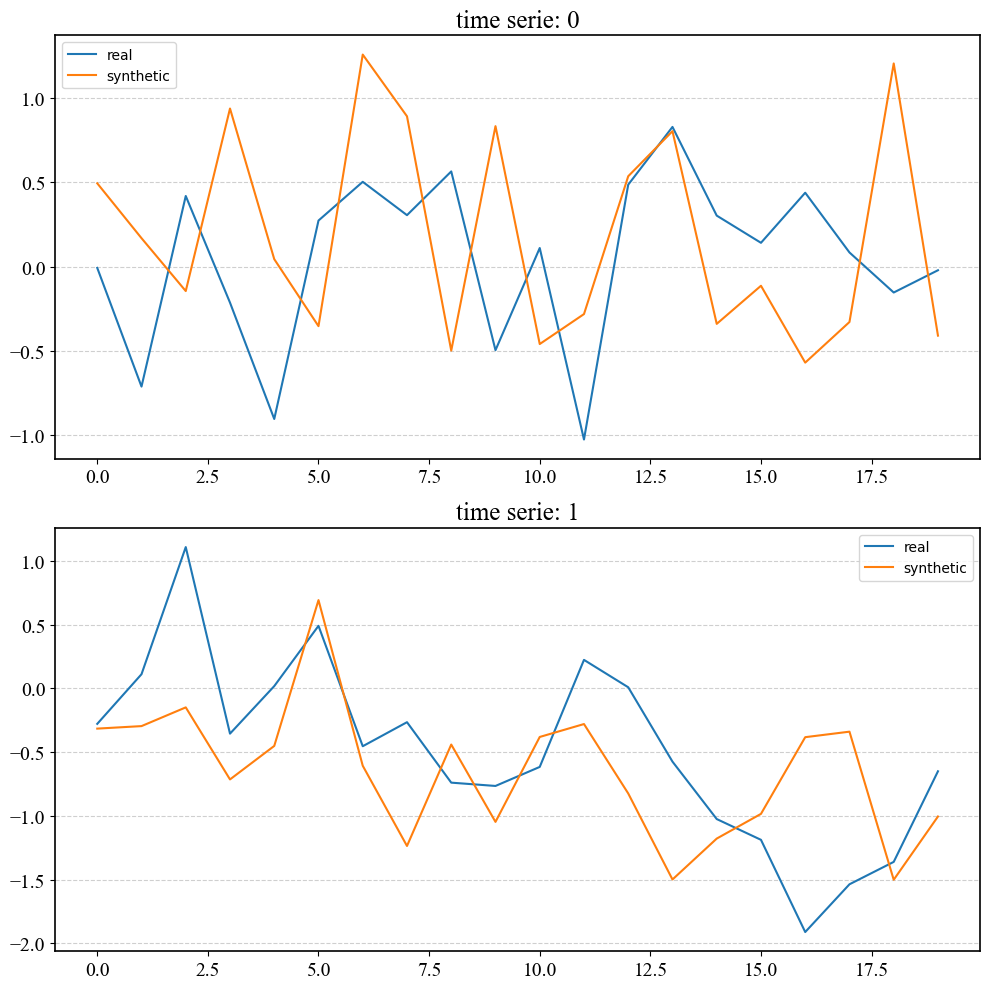

In [35]:
for i in np.random.choice(len(test_data), size=1):
    visualize_time_series(test_data[i], first_synthetic_data[i])

### Diversity

Do the generated samples cover the distribution of the real data?


To answer this question, we apply t-SNE or PCA to both the original and synthetic datasets (after flattening the temporal dimension). Here we project the data into 2-dimensional space, allowing us to visually assess how closely the distribution of the generated samples resembles that of the real data.

In [36]:
# get the first time series
test_single_series = test_data[..., 0]
synthetic_single_series = first_synthetic_data[..., 0]

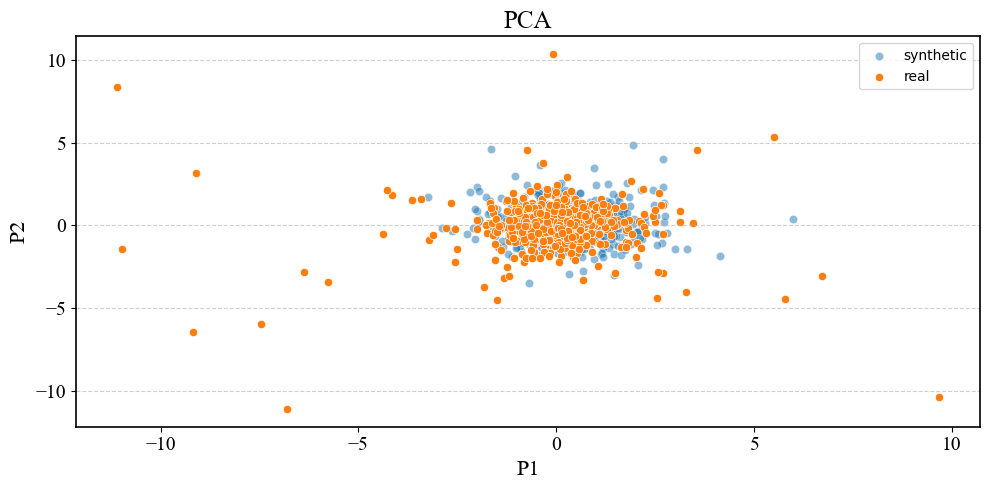

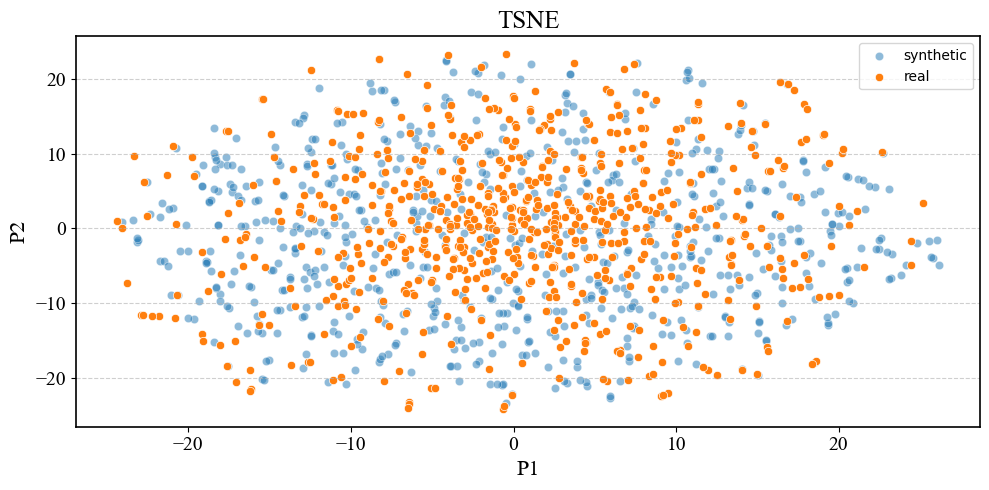

In [37]:
# Visualization of 2D PCA projection
visualize_2d_pca(test_single_series, synthetic_single_series)
# Visualization of 2D TSNE projection
visualize_2d_tsne(test_single_series, synthetic_single_series)

### Discriminative and Predictive Scores

- The **discriminative score** evaluates how well a classifier can distinguish real data from synthetic data by measuring metrics like accuracy.
  
- The **predictive score** measures how useful synthetic data is for forecasting tasks by training a model to predict the next value and comparing its performance to a model trained on real data.

For simplicity, we use a single-layer `LSTM` based architecture for both the classifier and the regressor, without any architecture search or hyperparameter tuning. More details can be found in the `EvaluationGenerativeModels.ipynb` notebook.

Below, we provide both scores

In [38]:
# compute scores
predictive_scores, discrimnative_scores = evaluate(
    test_data,
    synthetic_data_iters,
    random_state=ENV_CONFIG["random_state"],
    max_iters=DATA_CONFIG["num_eval_iterations"])

  0%|          | 0/50 [00:00<?, ?it/s]

Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpa8whfhra..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmp6170svkk..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpb4odsss1..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmp19g5l8pd..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpxuvhjn6_..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmp0zfh8eio..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpsidh5gou..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmphi16auuf..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmp2o00x8i7..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmp4qxdoxep..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpoxaig41x..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpr8cq66iq..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpdpyehobp..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpxoudydp6..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpa2yjw_8c..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpky5cqf39..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpwpz52_j3..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpk699ekra..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpo1a2tgsi..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpgte340ui..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpgvksupta..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpghy6w0sw..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpw9kksbjc..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpd7xx06ki..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpc3qf2iyd..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmp3ku5dhrh..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpjspdrbrk..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpg1k8owhf..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpj9ly1bjd..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmp3lrv61zo..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmp46v00nhv..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpc_n5xu14..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpnxutcn29..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpi5lxsqym..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpx9ucc6_j..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmp7e623p9s..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpjakeu6uo..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmp73610u6s..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmp_qe3n5tx..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpufvodord..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpe5qg7z7q..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpie7zxap7..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmp5m9o8o5n..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmptrzen1q5..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmp8lg_tux6..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmp9q58_0tw..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmp3mnylhih..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpnkgnmocl..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpq8hid68w..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmp1iqyw3o3..


`Trainer.fit` stopped: `max_steps=1000` reached.


  0%|          | 0/50 [00:00<?, ?it/s]

Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottle

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpe_244kej..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpsub_264f..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmp3pj1sout..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpnsz_wo3a..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmp25hpyy8y..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpa1zxptzw..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmptndpf74e..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmp3yjap4wy..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmp6tnaap2u..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpohaav97p..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmp8fnpg0g4..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmp8bd_orb8..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpyh9vvah5..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpr6qy1ot1..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpu6fgplfj..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmp0e1pj0x7..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpj4t2yind..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpl_6l0rur..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmphy_4p83p..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpama8usip..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpna92tjxw..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpnclo1vky..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpp0r9hqmg..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmp0ow42gp6..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpc1u2xu16..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmp6xtivu_q..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmp7csfusf2..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpvm0qbopk..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmp8z3qz7p1..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmp33ibqm8d..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmp8ztaabkd..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmplhrhz0pv..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpnv_r61f7..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmprctb_old..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpdgqpiwq8..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpi4fnicsp..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpm6tj61_5..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmp413p32pq..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmplly3iie8..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpkd9l68vp..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpwv5g208g..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpt6g3arvx..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpadkh6u26..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpc1p0dlaf..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmp_uh830jx..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpjmdtlto0..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpoxj0l_6o..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmp2zp7eznh..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmp50wncrs5..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpq2nmt1xh..


`Trainer.fit` stopped: `max_steps=1000` reached.


In [39]:
# Display the discriminative scores 
discrimnative_scores

,count,mean,std,min,25%,50%,75%,max
auc,50.0,0.975308,0.007115,0.955720,0.970631,0.975418,0.979753,0.991715
precision,50.0,0.914946,0.029186,0.843137,0.897995,0.916624,0.937417,0.967742
recall,50.0,0.912296,0.028761,0.851852,0.898148,0.911111,0.933333,0.970370
f1,50.0,0.912981,0.015954,0.866426,0.901022,0.912970,0.924792,0.952727
acc,50.0,0.913037,0.016312,0.862963,0.903704,0.914815,0.925926,0.951852


In [40]:
# Display the predictive scores 
predictive_scores

,count,mean,std,min,25%,50%,75%,max
MSE,50.0,0.957610,0.063316,0.810282,0.918841,0.941589,0.989975,1.111357
MAE,50.0,0.628381,0.016779,0.596099,0.617248,0.628704,0.637959,0.674694
MAPE,50.0,352.801455,56.216216,235.421705,315.699404,360.858583,389.646566,521.300888
